# TP : Résolution de l'équation de Vlasov-Poisson 1D-1D par une méthode semi-lagrangienne

In [2]:
# Basic imports 
import numpy as np 
import matplotlib.pyplot as plt 

On s'intéresse à l'équation de Vlasov  (évolution de la distribution des électrons dans un plasma) couplée avec l'équation de Poisson (évolution du champ électrique) 

\begin{equation}
\begin{cases}
\partial_t f + v \,\partial_x f - E(x,t) \,\partial_v f = 0 \\ 
\\ 
\partial_x E = \rho(x,t) = 1 - \int f(x,v,t) \,dv 
\end{cases}
\end{equation} 


## Discrétisation de l'espace des phases 

On considère un espace des phases en deux dimensions (une d'espace et une de vitesse) $\Omega = ]-\pi, \pi[^2 \subset \mathbb{R}^2$ que l'on va discrétiser par une grille uniforme $\mathcal{M} = \{(x_i, v_j)\}_{i= 0\,, \cdots, \,n_x-1\,,\,j=0\,, \cdots,\, n_v-1, }\subset \Omega$ 

In [3]:
nx = 100; nv = 100
dx = 2*np.pi / (2*nx) ; dv =2*np.pi / (2*nv)
dt = 1e-2
L = np.pi   
x = np.linspace(-L, L, num=nx, dtype=float)
v = np.linspace(-L, L, num=nv, dtype=float)
xx, vv = np.meshgrid(x,v) 

## Condition initiale 

On se donne une condition initiale en distribution de particules $f_0(x,v)$ 

In [16]:
f = lambda x, v : (1 / 2*np.pi)*np.exp(-0.5*(x**2+v**2))


Text(0, 0.5, '$v$')

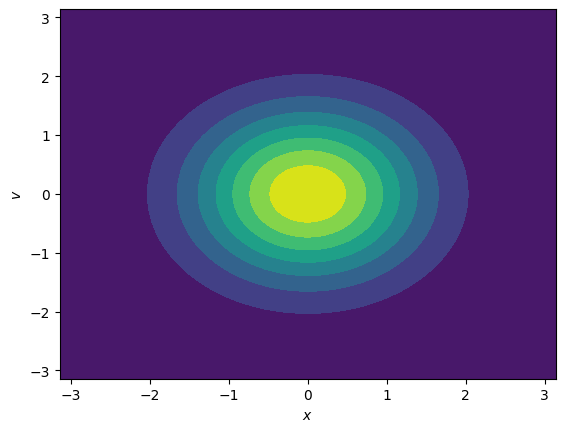

In [5]:

f_zero = f(xx, vv)
plt.contourf(x, v, f_zero)
plt.xlabel(r'$x$')
plt.ylabel(r'$v$')  

## Résolution de  l'équation de Poisson

La partie poisson du problème s'écrit 

\begin{equation}
\tag{P}
\partial_x E = \rho(x,t) = 1 - \int f(x, v, t) \,\text{d}v
\end{equation}

On va résoudre ce problème en discrétisant $f$ en modes de Fourier selon 
$$ f^n(x,v) = f(x,v, t_n) = \frac{1}{2\pi} \sum\limits_{k,l} c^n_{k,l} \, e^{i k.x} e^{i l.v} $$
Ainsi 
\begin{align*}
\rho^n(x, v) & = 1 - \frac{1}{2\pi} \sum\limits_{k,l} c^n_{k,l} \, e^{i k.x} \underbrace{\int e^{i l.v} \,\text{d}v}_{=0 \text{ si } l\neq 0 \text{ et } 2\pi \text{ sinon}} \\ 
             & = 1 - \sum\limits_{k} c^n_{k,0} \, e^{i k.x}  \\ 
             & = \sum\limits_{k} \tilde{c_k}^n \, e^{i k.x},         
\end{align*}
en posant $$\tilde{c_k}^n = 
            \begin{cases} 
                1 - c^n_{k,0} & \text { si } k=0 \\
                - c^n_{k,0} & \text{ sinon.}
            \end{cases} 
            $$
On écrit la somme de Fourier pour le champ électrique : 
$$ E^n(x) = \frac{1}{2\pi} \sum\limits_{j} d_j^n \, e^{i j.x} $$ 
donc 
$$ \frac{\text{d} E^n}{\text{d} x} = \frac{1}{2\pi} \sum\limits_{j} i j\, d_j^n \, e^{i j.x} $$

et par identification (unicité) des coefficients de Fourier on obtient $d_k^n = \frac{\tilde{c_k}^n}{ik} \text{ pour } k\neq 0$. La valeur de $d_0^n$ qui correspond à la moyenne du champ électrique peut être choisie librement et on prendra par exemple $d_0^n=0$.

## Calcul des coefficients de fourier et approximation de la série 

On considère une fonction $f$ $2\pi$-périodique définie sur $]-\pi, \pi[$ d'une variable $x$ 1D dont on cherche à calculer les coefficients de Fourier seulement à partir de sa connaissance sur une grille discrétisée $\{x_l\}_{l=0, \,\cdots,\, n_x-1}$.

Le $k$-ème coefficient de Fourier de $f$ noté $c_k$ est défini par 

$$ c_k = \int_{-\pi}^{\pi} f(x) e^{-inx} dx $$ 

Nous allons approcher ces coefficients à partir de notre discrétisation de l'espace des phases en $x$ avec une somme de Riemman selon : 

$$ c_k^{n_x}= \frac{2\pi}{n_x}\sum\limits_{l=0}^{n_x-1} f_l \, e^{-ik\,x_l} \underset{n_x \to +\infty}{\longrightarrow} c_k .$$ 

Avec $\frac{2\pi}{n_x} = \Delta x$, l'incrément en $x$.

La fonction $f$ est donc approchée par sa série de fourier (où les coefficients de Fourier sont approchés selon ce qui précède) 

$$ f(x) \sim \sum\limits_{k\in\mathbb{Z}} c_k^{n_x} \,e^{ik.x}. $$ 

On introduit ainsi une nouvelle étape de discrétisation en tronquant cette somme de Fourier afin de reconstruire la fonction numériquement. Soit donc $K\in \mathbb{N}^*$ tel qu'on fait l'approximation 

$$ f(x) \sim \sum\limits_{k = -K}^{K} c_k^{n_x} \, e^{ik.x}.$$ 


In [166]:
K = 50
k_values = np.arange(-K, K+1)


On s'intéresse ainsi au calcul des coefficients $c_k$ pour $k= -K, \,\cdots,\, K$ et l'on voit que l'on peut écrire le calcul sous forme matricielle selon : 

 
$$
\begin{pmatrix}
c_{-K} \\
\vdots \\ 
c_{K}
\end{pmatrix}
= 
\frac{2\pi}{n_x} 
\tilde{F}
\begin{pmatrix}
f_0 \\ 
\vdots \\ 
f_{n_x -1} 
\end{pmatrix}
,
$$

Où $\tilde{F}\in \mathbb{R}^{(2K + 1) \times n_x}$ est la matrice définie par 
$$ \tilde{F} = [ \,e^{-ik\,x_l}\, ]_{k = \, -K, \cdots, \,K ;\, l=\,0, \cdots,\, n_x-1}.$$ 

In [201]:
F = np.zeros(((5,5,5)))
m = np.ones((5,5))

In [203]:
np.shape(F @ m) 

(5, 5, 5)

In [86]:
import itertools as it 

In [87]:
print(np.arange(-K, K+1)) 

[-2 -1  0  1  2]


In [137]:
def build_F_tilde(x):
    # nx = len(x) 
    F_tilde = np.array([np.exp(-k*1j * x[l]) for k,l in it.product(k_values, range(nx))], dtype=complex)
    F_tilde.resize((2*K+1,nx)) 
    return F_tilde

def fourier_coeffs_1D(x, f, F_tilde):
    # nx = len(x) 
    c = ((2 * np.pi) / nx) * F_tilde @ f 
    return c

On écrit une fonction qui reconstruit une fonction en calculant sa série de fourier tronquée à partir de ses coefficients de fourier 

In [138]:
def fourier_reconstuction(x, c):
    s = lambda x: (1 / (2*np.pi)) * np.sum([coeff*np.exp(1j*k*x) for k, coeff in zip(k_values, c)])
    return np.array([s(_x) for _x in x]) 

## Test de la reconstruction 

In [149]:
g = lambda x : np.sin(x) + np.sin(2*x) + np.cos(x) 
g_h = g(x)

In [150]:
F = build_F_tilde(x) 
print(np.shape(F))
c = fourier_coeffs_1D(x, g_h, F) 

(41, 100)


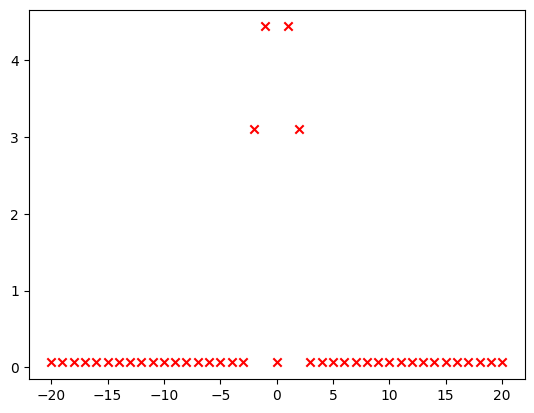

In [151]:
plt.scatter(np.arange(-K, K+1), np.abs(c), c='red', marker='x') 

In [152]:
rec = fourier_reconstuction(x, c)

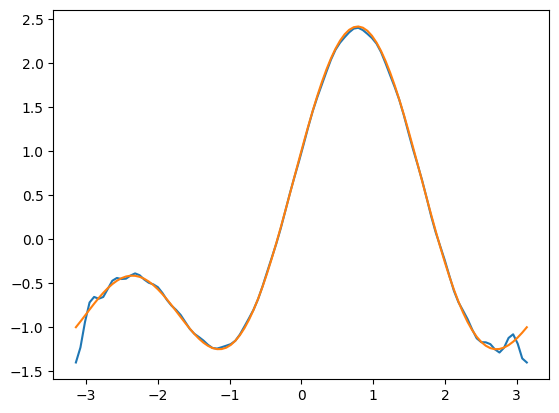

In [153]:
plt.plot(x, rec) 
plt.plot(x, g_h)

## Calcul des modes en $l=0$ 

In [155]:
F = build_F_tilde(x)
c = fourier_coeffs_1D(x, f_zero[:,0], F) 

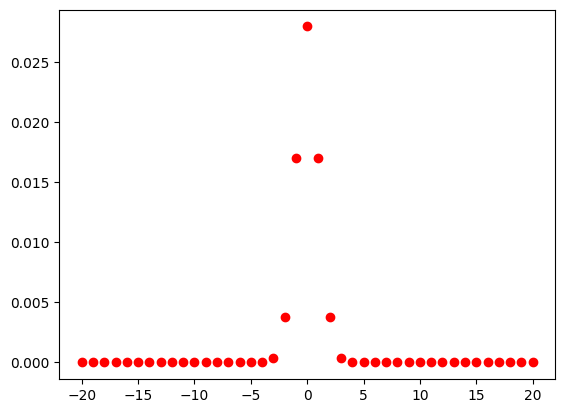

In [156]:
plt.scatter(k_values, np.abs(c), c='red')

In [157]:
f_zero_rec = fourier_reconstuction(x, c) 

/home/murloc/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


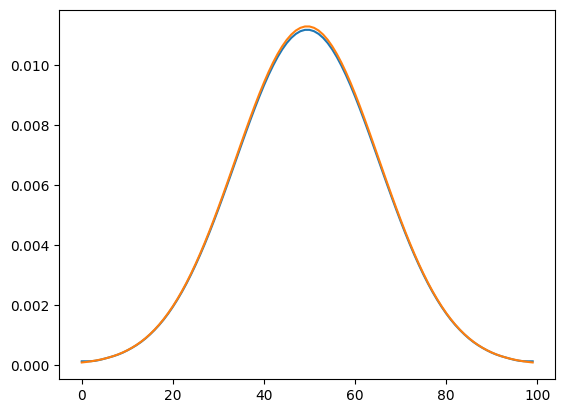

In [159]:
plt.plot(f_zero_rec)
plt.plot(f_zero[:,0]) 

In [16]:
import itertools as it 

In [22]:
## Not Needed by now 
def reconstuction_2D(x, v, c):
    nx = len(x) ; nv = len(v) 
    rec = np.zeros((nx,nv), dtype=complex)
    rec_function = lambda x,v : np.sum([c[k,l] * np.exp(1j*k*x) * np.exp(1j*l*v) for k,l in np.ndindex((nx,nv))])
    return rec_function
    # for k,l in np.ndindex((nx,nv)):
    #     rec[k,l] = np.sum([c[k,l] * np.exp(1j*k*x[k]) * np.exp(1j*l*v[l]) for k,l in np.ndindex((nx,nv))]) 
    # return rec 

## Code pour la résolution de Poisson 

Tous les éléments sont ainsi en place afin de résoudre l'équation de Poisson grâce aux séries de fourier 

In [191]:
def solve_poisson(x, f):
    nx = len(x) 
    F = build_F_tilde(x)
    c = fourier_coeffs_1D(x, f[:,0], F)
    c_tilde = np.zeros(2*K+1, dtype=complex)
    c_tilde[0] = 1 - c[0] 
    for k in range(1, 2*K+1):
        c_tilde[k] = - c[k]      
    d = np.zeros(2*K+1, dtype=complex)
    # Electric field mean has to be fixed
    d[0] = 0 
    for k in range(1, 2*K+1):  
        d[k] = (c_tilde[k]) / (k*1j)
    _E = fourier_reconstuction(x, d)
    return _E

In [187]:
E_zero = solve_poisson(x, f_zero)

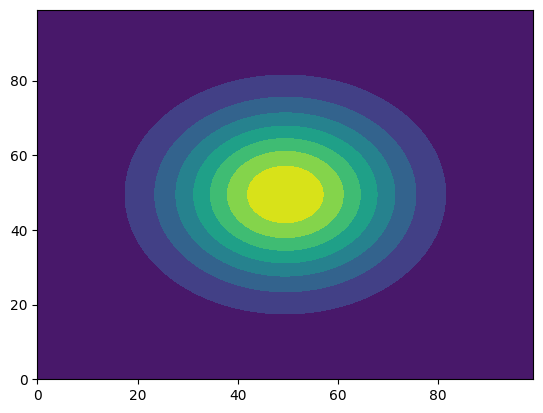

In [188]:
plt.contourf(f_zero) 

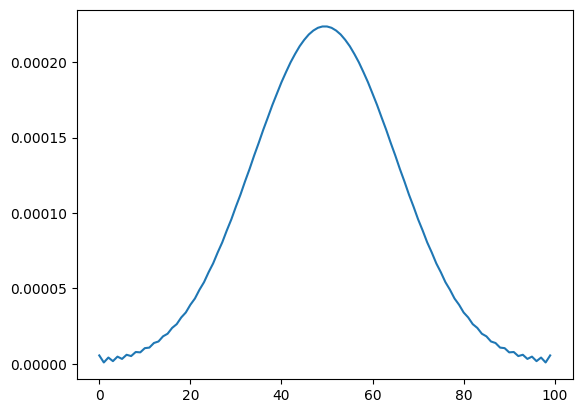

In [189]:
plt.plot(np.abs(E_zero)) 

## Transport dans l'équation de Vlasov


L'équation de Vlasov peut être décomposée en deux phénomènes décrivant son évolution :
- une advection en $v$ causée par le champ $E$ : 

\begin{equation}
\tag{a}
\partial_t f - E(x,t) \, \partial_v f = 0 
\end{equation}

- une advection en $x$ causée par le champ de vitesses : 

\begin{equation}
\tag{b}
\partial_t + v \,\partial_x f = 0
\end{equation}

Ces équations sont des équations de transport, dont les solutions analytiques peuvent être obtenues en appliquant la "méthode des caractéristiques".


### Méthode des caractéristiques



On considère une équation de transport 1D homogène à une dimension avec champ de vitesse $a(x,t)$: 

\begin{equation}
\tag{T}
\partial_t u + a(x,t)\,\partial_x u = 0
\end{equation}

Soit $(t,x) \in \mathbb{R}^{+} \times \mathbb{R}$ et  $X(s;t,x), s\in \mathbb{R}$ une courbe paramétrée lisse telle que $X(t;t,x) = x$.

On effectue le calcul de $\frac{d}{ds}u(X(s;t,x), t)$. 

\begin{align*} 
    \frac{\text{d}}{\text{d}s}u(X(s;t,x), s) = \partial_t u(X(s;t,x), s) + \frac{\text{d}X}{\text{d}s}(s;t,x)\, \partial_x u(X(s;t,x),s) & \quad \text{ (règle de la chaine)} 
\end{align*} 

On voit donc avec $(\text{T})$ que cette égalité se réduit à zéro si on impose la condition 

\begin{equation}
\tag{C}
\frac{\text{d}X}{\text{d}s} (s; t,x) = a(X(s;t,x),s) 
\end{equation}

On a ainsi réduit la résolution de l'EDP $(\text{T})$ à la résolution de l'EDO $(\text{C})$ dite "équation des caractéristiques". 


Dans le cas simple où le champ de vitesses $a$ est constant, l'équation $(\text{C})$ s'intégre en 
$$X(s;t,x) = as + b$$ 

et le coefficient b est déterminé par la condition

$$X(t;t,x) = x \implies b = x - at$$ 

de sorte que 

$$X(s;t,x) = x + a(s-t).$$

L'intérêt d'imposer l'équation des caractéristiques $\text{(C)}$ est de fixer 

$$\frac{\text{d}}{\text{d}s}u(X(s;t,x), s)= 0$$

et ainsi $\textbf{la solution est constante le long des courbes caractéristiques}$ de sorte que pour tout $(x,t)$

$$u(x,t) = u(X(t;t,x), t) = u(X(0;t,x), 0) = u_0(x-at)$$ 

où $u_0(x) = u(x, t=0)$ est la condition initiale. 



On voit ainsi ques les équations $(a)$ et $(b)$ sont analytiquement résolues par 

\begin{equation}
\tag{a*}
    f(x,v,t) = f_0(x, v + E(x)\,t)
\end{equation}
et
\begin{equation}
\tag{b*}
    f(x,v,t) = f_0(x - v\,t, v)
\end{equation}
respectivement. 

Seulement dans notre cas où l'on cherche à résoudre l'équation de Vlasov-Poisson (où l'évolution du champ électrique $E$ est couplée à l'équation de Vlasov) nous faison face à deux difficultés : 

1) Quel champ $E$ utiliser dans l'étape d'advection en $v$ ? Celui-ci évolue en effet simultanément par rapport à $f$. Cette question va nous amener à définir un schéma de $\textbf{splitting}$.
2) Les points $x-v\,t$ ou $v + E(x)\,t$ n'ont aucune raison particulière d'appartenir au maillage $\mathcal{M}$. Ce qui va nous amener à définir une étape $\textbf{d'interpolation}$ dans le schéma. 

## Interpolation en séries de Fourier 

On suppose connus la décomposition en série de fourier tronquée de $f$ à l'étape $n$ selon : 

$$ f^n(x, v) = \frac{1}{2\pi}\sum\limits_{k= -K}^{K}\sum\limits_{l = -L}^L c_{k,l}^n \, e^{i k.x}e^{i l.v} $$ 

L'interpolation consiste ainsi à évaluer cette expression aux points d'interpolation $x - v\Delta t$ ou $v + E(x)\frac{\Delta t}{2}$ par exemple. 

## Calcul des coefficients de fourier en 2D 

On voit ainsi qu'on a besoin de calculer les coefficients de fourier de $f$ dans les deux dimensions $(x,v)$ pour réaliser l'interpolation. On introduit donc de même le paramètre $L$.

In [196]:
L = K 
l_values = np.arange(-L, L+1) 

De manière similaire à ce qui a été fait en dimension 1 on calcule les coefficients de fourier en 2D en résolvant un système matriciel qui peut s'écrire : 

$$ 
\begin{pmatrix}
c_{-K, -L} &  \cdots & c_{-K, L} \\ 
\vdots   & & \vdots \\ 
c_{K, -L} & \cdots & c_{K, L} 
\end{pmatrix}
= 
\frac{4\pi^2}{n_x\,n_v}
\tilde{F}^{2D}
\begin{pmatrix}
f_{0,0} & \cdots & f_{0, n_v-1} \\ 
\vdots &  & \vdots \\ 
f_{n_x -1, 0} & \cdots & f_{n_x-1, n_v-1} 
\end{pmatrix}
$$

Où $\tilde{F}^{2D}\in\mathbb{R}^{(2K+1) \times (2L+1) \times n_x \times n_v}$ est le tenseur d'ordre 4 défini par 

$$ \tilde{F}^{2D} = [ e^{-ik.x_m}e^{-il.v_n}]_{\,k,l,m,n}  \quad k=-K,\cdots,K;\, l=-L, \cdots, L;\, m=0,\cdots, n_x-1;\, n=0, \cdots, n_v-1$$ 



In [204]:
def build_F_tilde_2D(x, v):
    F_tilde = np.array([ np.exp(-k*1j * x[m])* np.exp(-l*1j * v[n]) for k,l,m,n in it.product(k_values, l_values, range(nx), range(nv))], dtype=complex)
    F_tilde.resize((2*K+1, 2*L+1, nx, nv)) 
    return F_tilde

In [205]:
def fourier_coeffs_2D(x, v, f, F_tilde):
    return ((4*np.pi**2) / (nx*nv)) * F_tilde @ f 
    

In [206]:
F = build_F_tilde_2D(x, v) 
c = fourier_coeffs_2D(x, v, f_zero, F) 

KeyboardInterrupt: 

Juste pour voir la différence ... :( 

In [207]:
c_fft = np.fft.fft2(f_zero)

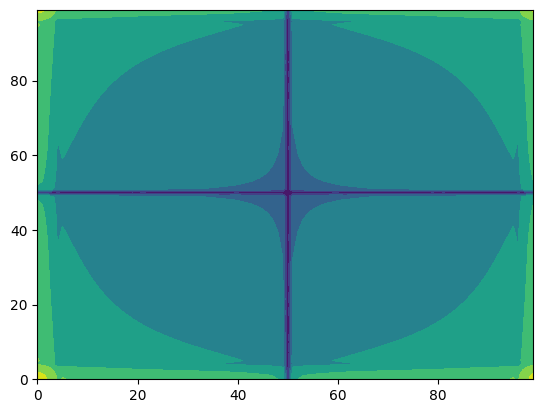

In [209]:
plt.contourf(np.log(np.abs(c_fft))) 

## Schéma de Splitting semi-lagrangien

Nous détaillons ici le schéma de splitting que nous allons mettre en place pour la résolution du système de Vlasov-Poisson. 

1. $\textbf{Initialisation}$ : On se donne une condition initiale $f_0$, avec laquelle on calcule le champ initial $E_0$ en résolvant $(\text{P})$
2. $\textbf{Itération}$ : 
    - A partir de $(E^n, \,f^n)$ calculés à l'étape $n$ on calcule l'advection en $v$ sur un demi pas de temps $f^*(x,v) = f^n(x, v + E^n(x)\,\frac{\Delta t}{2})$ qui est solution de
        $$ \partial_t f - E^n(x)\,\partial_v f = 0.$$
        Les valeurs de $f^*$ étant obtenues par interpolation de $f^n$ selon la dimension $v$.

    - A partir de $f^*$ on calcule l'advection en $x$ sur un pas de temps complet $f^{**}(x,v) = f^*(x - v\,\Delta t, v)$ qui est solution de 
        $$ \partial_t f + v \,\partial_x f = 0.$$ 
        Les valeurs de $f^{**}$ étant également obtenues par interpolation de $f^{*}$ selon la dimension $x$.

    - On calcule le nouveau champ électrique $E^{n+1}(x)$ en résolvant $(\text{P})$ à partir de la distribution $f^{**}$.
    
    - Enfin, on effectue une dernière advection également avec une étape d'interpolation en $v$ à partir du nouveau champ électrique et de $f^{**}$ pour obtenir $f^{n+1}(x,v) = f^{**}(x, v+E^{n+1}(x)\,\frac{\Delta t}{2})$ qui est solution de 
        $$ \partial_t f - E^{n+1}(x)\,\partial_v f = 0.$$ 
    
    - On stocke $(f^{n+1}, \,E^{n+1})$.
